In [1]:
from __future__ import print_function
from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

E_F = 0 #eV
T = 300 
hbar = 6.5821e-16 #eV.s (SI- 1.054571817e-34 J.s)
k_b = 8.6173e-5 #eV/K (SI- 1.380649e-23 J/K)

def f(E):
    return 1.0/(1+np.exp((E-E_F)/(T*k_b)))

def fdash(E): #derivative wrt E
    return -1/(T*k_b)*np.exp((E-E_F)/(T*k_b))/(1+np.exp((E-E_F)/(T*k_b)))**2

In [2]:
# define lattice vectors
lat=[[1.0,0.0],[0.5,np.sqrt(3.0)/2.0]]
# define coordinates of orbitals in terms of lattice vectors
orb=[[1./3.,1./3.],[2./3.,2./3.]]

# make two dimensional tight-binding graphene model
my_model=tb_model(2,2,lat,orb,nspin=2)

# set model parameters
delta=0.0
t=1.0

# set on-site energies
my_model.set_onsite([-delta,delta])
# set hoppings (one for each connected pair of orbitals)
# (amplitude, i, j, [lattice vector to cell containing j])

my_model.set_hop(t, 0, 1, [ 0, 0])
my_model.set_hop(t, 1, 0, [ 1, 0])
my_model.set_hop(t, 1, 0, [ 0, 1])

# print tight-binding model- my_model.display()

N=100

k_vec = my_model.k_uniform_mesh([N,N])

In [3]:
# obtain eigenvalues and eigenvectors
eval, evec = my_model.solve_all(k_vec,True)

E=eval.reshape(4,N,N) #eV (SI- *1.6e-19 J)
evec=evec.reshape(4,N,N,2,2)

print(evec.shape) #evec[band][kx][ky][j][nspin]
evec = evec[:,:,:,0,:]+evec[:,:,:,1,:] #eliminating j- naive sum
print(evec.shape) #evec[band][kx][ky][nspin]

(4, 100, 100, 2, 2)
(4, 100, 100, 2)


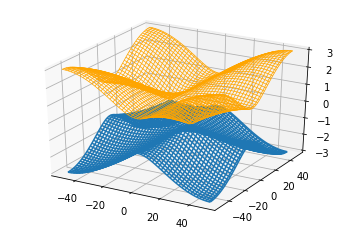

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = y = np.linspace(-N//2, N//2, N)
k_X, k_Y = np.meshgrid(x, y)

ax.plot_wireframe(k_X, k_Y, E[0])
ax.plot_wireframe(k_X, k_Y, E[2],0.75,color='orange')

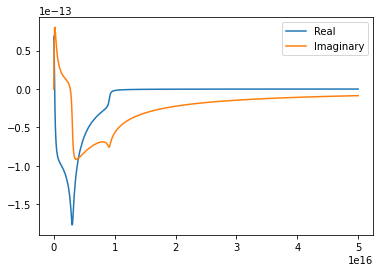

In [5]:
constants = hbar/(2*np.pi**2)*1j # fitting-ish parameter

def kubo_arr(E, omega, Gamma):
    conductivity = np.zeros(shape=(omega.shape),dtype=complex)
    for i in range(len(omega)):
        ku=0
        for n in range(len(E)): #band index n
            for m in range(len(E)): #band index m
                
                spinfrac = (np.absolute(np.sum(np.conj(evec[n])*np.flip(evec[m],axis=2), axis = 2)))**2
                if n!=m:
                    if(len(np.where(E[m]-E[n]==0)[0])>0): #if bands are degenerate or "intersect"
                        contribution = -fdash(E[n])
                    else:
                        contribution = (f(E[m])-f(E[n]))/(E[m]-E[n])
                else:
                    contribution = -fdash(E[n])

                ku += contribution*spinfrac/(hbar*omega[i]+Gamma*1j-E[m]+E[n])
        conductivity[i]=constants*np.sum(ku)
            
    return conductivity

gamma = 0.1 #eV (SI- *1.6e-19 J)
freq = np.linspace(0,5e16,750) #Hz
sigma = kubo_arr(E, freq, gamma)
plt.plot(freq,sigma.real,label='Real')
plt.plot(freq,sigma.imag,label='Imaginary')

plt.legend()

In [6]:
np.where(sigma.real<0)[0] #bad behavior check

array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 18

(4, 100, 100, 2)


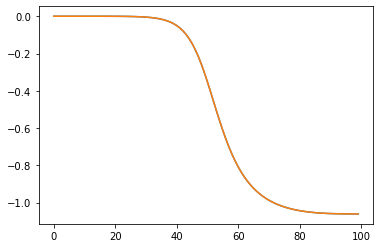

In [7]:
#Playing with evec:

print(evec.shape)

plt.plot(evec[0,0,:,1].real+evec[1,0,:,1].real)
#plt.plot(evec[0,0,:,1].imag+evec[1,0,:,1].imag)

plt.plot(evec[0,0,:,1].real+evec[0,0,:,0].real)
#plt.plot(evec[0,0,:,0])